# Importing the libraries and data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
df = pd.read_csv("D:/Chools/Day_06/Universities.csv")

In [3]:
df.head()

,Univ,SAT,Top10,Accept,SFRatio,Expenses,GradRate
0,Brown,1310,89,22,13,22704,94
1,CalTech,1415,100,25,6,63575,81
2,CMU,1260,62,59,9,25026,72
3,Columbia,1310,76,24,12,31510,88
4,Cornell,1280,83,33,13,21864,90


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Univ      25 non-null     object
 1   SAT       25 non-null     int64 
 2   Top10     25 non-null     int64 
 3   Accept    25 non-null     int64 
 4   SFRatio   25 non-null     int64 
 5   Expenses  25 non-null     int64 
 6   GradRate  25 non-null     int64 
dtypes: int64(6), object(1)
memory usage: 1.5+ KB


In [5]:
df_cleaned = df.drop('Univ',axis=1)

### Visualizations

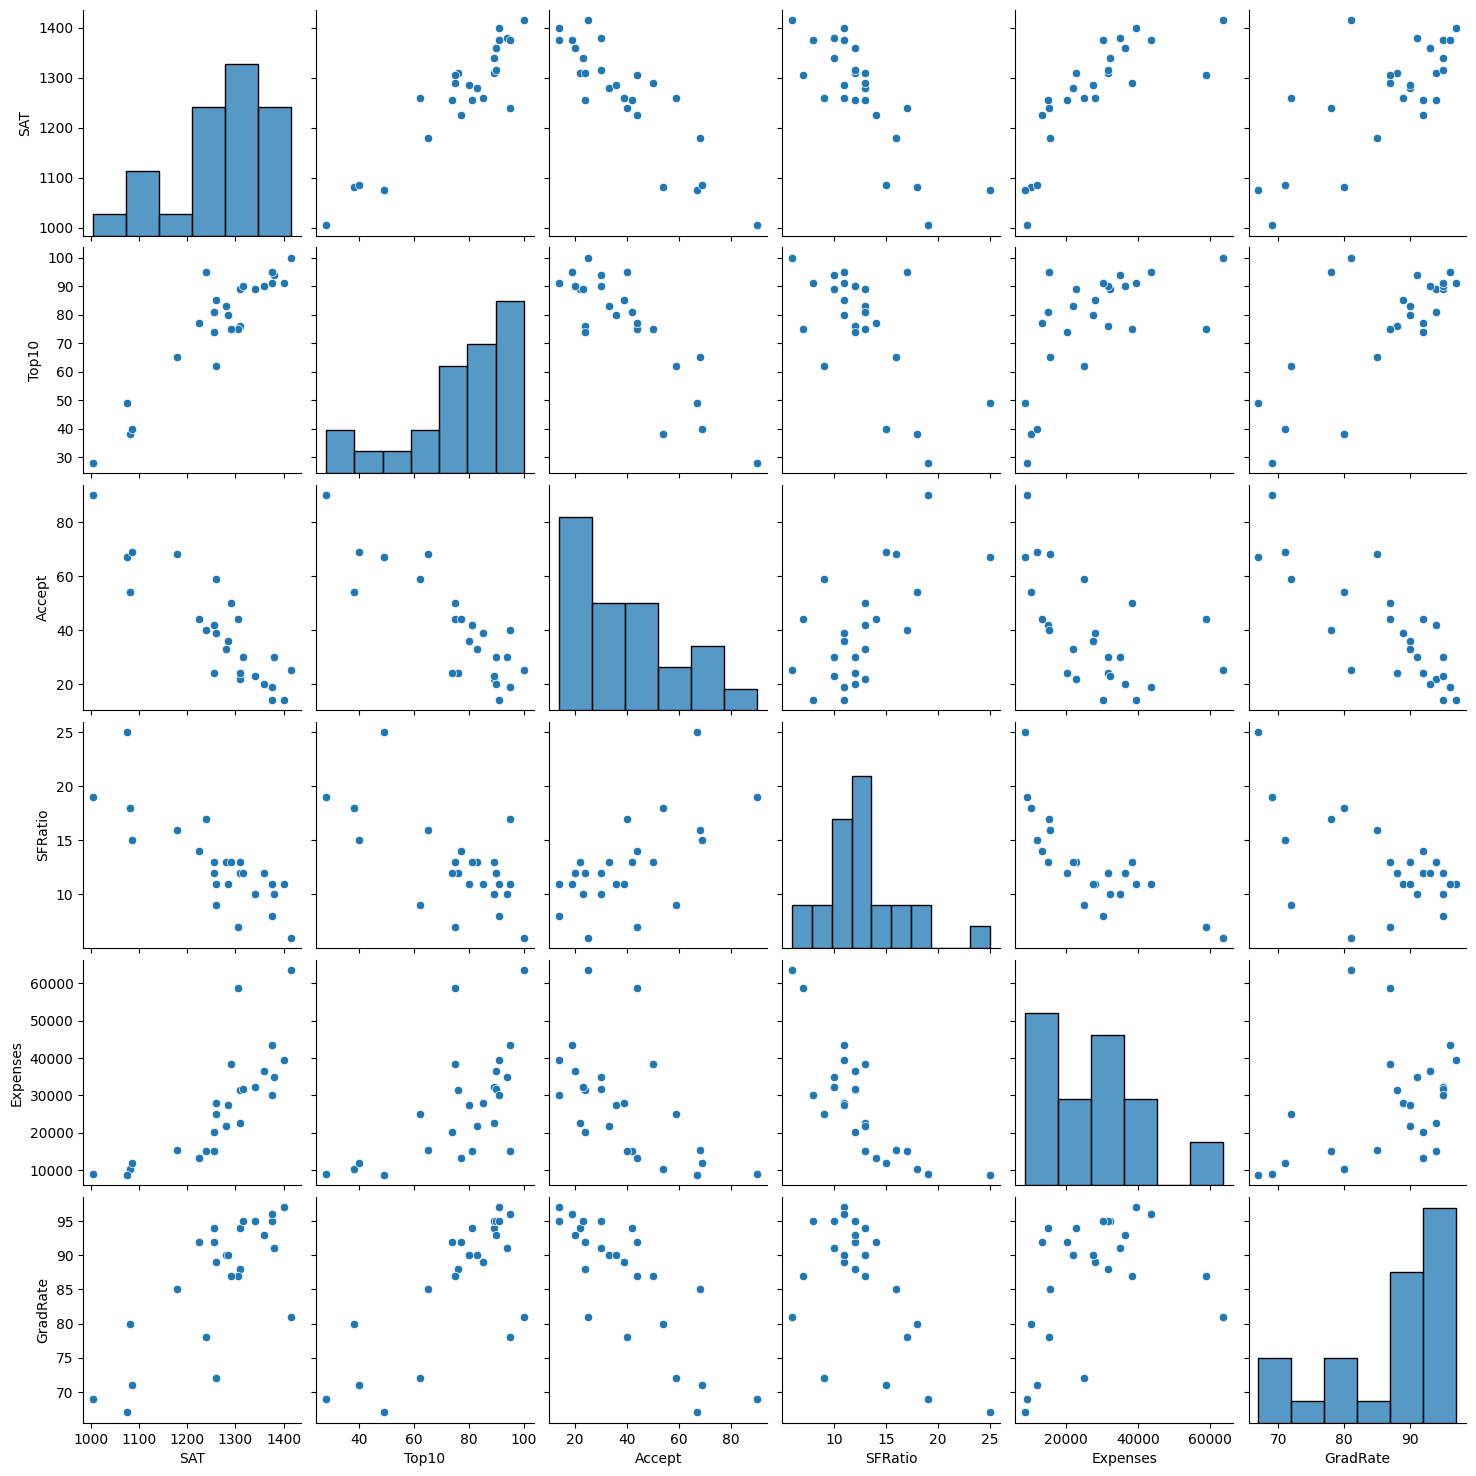

In [6]:
# Pairplot for visualizing relationships between variables
sns.pairplot(df_cleaned)
plt.show()

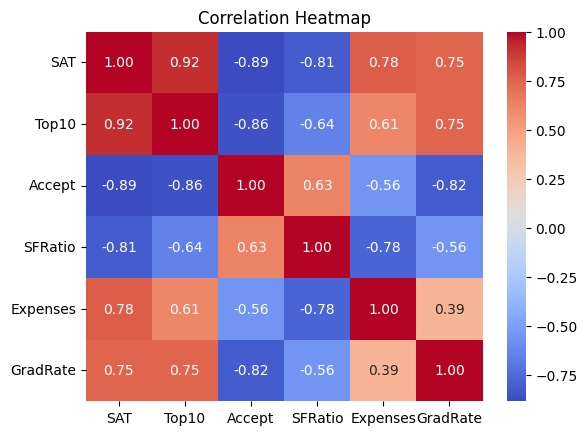

In [7]:
# Correlation heatmap
correlation_matrix = df_cleaned.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

### Calculating the VIF

In [8]:
def calculate_vif(data):
    # Standardize the features as VIF is scale-dependent
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    # Calculate VIF for each variable
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data_scaled, i) for i in range(data_scaled.shape[1])]
    
    return vif_data


In [9]:
# Assuming 'data_for_clustering' is your DataFrame with features
vif_result = calculate_vif(df_cleaned)

# Display the VIF results
print(vif_result)

   Variable        VIF
0       SAT  28.113281
1     Top10   9.613252
2    Accept   7.219904
3   SFRatio   4.291224
4  Expenses   4.243140
5  GradRate   3.453296


#### High VIF values indicate multicollinearity, suggesting that the variables in your dataset are highly correlated with each other. This can cause issues in regression models, affecting the stability and interpretability of the coefficients.

In [10]:
# Identify the variable with the highest VIF
max_vif_variable = vif_result.loc[vif_result['VIF'].idxmax(), 'Variable']

# Remove the variable with the highest VIF
data_for_clustering_reduced = df_cleaned.drop(columns=[max_vif_variable])

# Recalculate VIF
vif_result_reduced = calculate_vif(data_for_clustering_reduced)

# Display the updated VIF results
print(vif_result_reduced)


   Variable       VIF
0     Top10  4.395993
1    Accept  5.431078
2   SFRatio  3.206442
3  Expenses  2.995376
4  GradRate  3.433502


### Model fitting

In [11]:
# Use different linkage methods
linkage_methods = ['single', 'complete', 'average', 'centroid', 'ward']
clusters = {}

for method in linkage_methods:
    Z = linkage(df_cleaned, method)
    clusters[method] = fcluster(Z, t=5, criterion='maxclust')  
    # 't' is the number of clusters


In [12]:
from sklearn.metrics import silhouette_score

# Assuming 'clusters' is a dictionary containing different clustering results
# and 'method' is one of the linkage methods

best_method = None
best_score = -1

for method, labels in clusters.items():
    score = silhouette_score(df_cleaned, labels)
    print(f"Silhouette Score for {method} Linkage: {score}")
    
    if score > best_score:
        best_score = score
        best_method = method

print(f"\nBest Method: {best_method} Linkage with Silhouette Score: {best_score}")


Silhouette Score for single Linkage: 0.37762224689277146
Silhouette Score for complete Linkage: 0.5790958137838786
Silhouette Score for average Linkage: 0.5790958137838786
Silhouette Score for centroid Linkage: 0.5790958137838786
Silhouette Score for ward Linkage: 0.5790958137838786

Best Method: complete Linkage with Silhouette Score: 0.5790958137838786


#### The Silhouette Scores for the linkage methods other than "Single" are notably higher, indicating that the clusters formed by these methods are better separated and more distinct. The "Complete," "Average," "Centroid," and "Ward" linkage methods all have the same Silhouette Score of 0.58.

#### Therefore, based on the Silhouette Score, I have chosen "Complete Linkage" as the best method. This suggests that, according to the Silhouette metric, the clusters formed by "Complete Linkage" are well-defined and have a good separation between them.

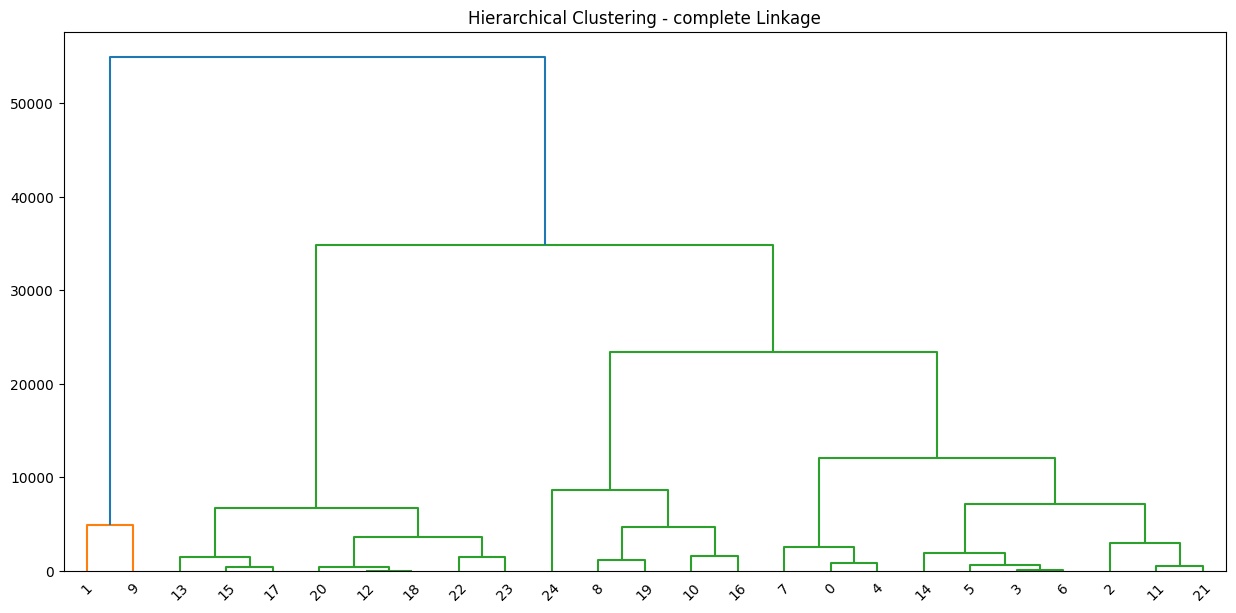

In [13]:

# Perform final clustering using the best method
final_Z = linkage(df_cleaned, best_method)
final_labels = fcluster(final_Z, t=5, criterion='maxclust')

# Visualize the dendrogram for the final clustering
plt.figure(figsize=(15, 7))
dendrogram(final_Z)
plt.title(f'Hierarchical Clustering - {best_method} Linkage')
plt.show()